In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sainsc import gaussian_kernel, read_StereoSeq

In [2]:
data_path = Path("data")
analysis_path = Path("brain")

stereo_seq_file = data_path / "StereoSeq" / "Mouse_brain_Adult_GEM_bin1.tsv.gz"
signature_file = Path("StereoSeq_Brain_segmentation_signatures.tsv")

In [3]:
# Palettes (for figures only)

kde_cmap = "magma"
assignment_score_cmap = "viridis"
cosine_cmap = "plasma"

In [4]:
bw = 8

stereo = read_StereoSeq(stereo_seq_file, resolution=500, n_threads=16)

signatures = pd.read_table(signature_file, index_col=0).loc[
    lambda df: df.index.isin(stereo.genes)
]

# ensure same kernel as in Julia
stereo.kernel = gaussian_kernel(bw, 2 * bw, truncate=2)
stereo.calculate_total_mRNA_KDE()
stereo.assign_celltype(signatures, log=True)

In [5]:
import h5py

with h5py.File(Path("julia") / "StereoSeq_Brain_results.h5", "r") as h5:
    kde_jl = h5["total_kde"][:]
    assignment_score_jl = h5["assignment_score"][:]
    cosine_similarity_jl = h5["cosine_similarity"][:]
    celltype_map_jl = h5["celltype_map"][:]
    celltypes_jl = h5["celltypes"][:]

celltypes_jl = [ct.decode() for ct in list(celltypes_jl)]

In [7]:
cmap = {
    "Astr1": "#BAAFFB",
    "Astr2": "#4E8817",
    "Astr3": "#787DA3",
    "Astr4": "#DA7879",
    "Astr5": "#E7CA2E",
    "DA neuron": "#656565",
    "Ependymal": "#5a0007ff",
    "EX": "#775613",
    "EX CA": "#4D86A3",
    "EX L2/3": "#4166AD",
    "EX L4": "#3D6B85",
    "EX L5/6": "#FAFF33",
    "EX L6": "#488854",
    "EX Mb": "#34347C",
    "EX thalamus": "#85CF5E",
    "Endothelium": "#CCC8FB",
    "Erythrocyte": "#94C351",
    "GN DG": "#8BC5ED",
    "IN Pvalb+": "#9c9a9b",
    "IN Pvalb+Gad1+": "#EED883",
    "IN Sst+": "#B88299",
    "IN thalamus": "#430B66",
    "IN Vip+": "#62AFC1",
    "Meninge": "#1B0083",
    "Microglia": "#525510",
    "OPC": "#A04540",
    "Olig": "#CB181B",
    "Smooth muscle cells": "#9FBDFB",
    "Unknown": "black",
}

## Check equality of assignment

The order of cell types might differ between the Julia and python implementation and we therefore first must match indices. Furthermore Julia is 1 based (with "missing" indicating no cell type) while in Python -1 is no cell type

In [6]:
from numba import njit


@njit
def map_ct_idx(map_in, jl2py):
    new_map = np.empty(shape=map_in.shape, dtype=jl2py.dtype)
    for i in range(map_in.shape[0]):
        for j in range(map_in.shape[1]):
            new_map[i, j] = jl2py[map_in[i, j]]
    return new_map


jl2py_idx = np.array(
    [stereo.celltypes.index(ct) if ct != "missing" else -1 for ct in celltypes_jl],
    dtype=stereo.celltype_map.dtype,
)

# julia indices start at 1 so we need to shift so they correspond to the indices of jl2py_idx
celltype_map_jl_pyindices = map_ct_idx(celltype_map_jl - 1, jl2py_idx)

In [7]:
# number of differentially assigned pixels
diff_celltype = celltype_map_jl_pyindices.T != stereo.celltype_map
np.sum(diff_celltype)

89

In [8]:
not_empty = stereo.celltype_map != -1

In [9]:
# number of differentially assigned pixels
np.sum(diff_celltype) / np.sum(not_empty)

9.249265203037999e-07

In [10]:
# maximum difference in KDE
diff_kde = np.abs(kde_jl.T - stereo.total_mRNA_KDE)

diff_kde.max()

1.0967255e-05

In [11]:
# median difference in KDE
np.median(diff_kde[not_empty])

2.3841858e-07

In [12]:
# maximum difference in cosine similarity
diff_cs = np.abs(np.nan_to_num(cosine_similarity_jl).T - stereo.cosine_similarity)

diff_cs.max()

2.9802322e-07

In [13]:
# median difference in cosine similarity
np.median(diff_cs[not_empty])

0.0

In [14]:
# maximum difference in assignment score
diff_as = np.abs(np.nan_to_num(assignment_score_jl).T - stereo.assignment_score)

diff_as.max()

0.08901336

In [15]:
# median difference in assignment score
np.median(diff_as[not_empty])

7.450581e-09

## Figure

In [40]:
from numba import njit


@njit
def apply_color(img_in, cmap):
    img = np.empty(shape=(*img_in.shape, 3), dtype=cmap[0].dtype)
    for i in range(img_in.shape[0]):
        for j in range(img_in.shape[1]):
            img[i, j, :] = cmap[img_in[i, j]]
    return img

In [41]:
from matplotlib.colors import to_rgb

color_map = [to_rgb(cmap[ct]) if ct in cmap else to_rgb("white") for ct in celltypes_jl]

color_map_int = tuple((np.array(c) * 255).round().astype(np.uint8) for c in color_map)

In [42]:
# Julia is 1 based
ct_im_jl = apply_color(celltype_map_jl - 1, color_map_int)

In [43]:
assignment_score_jl[np.isnan(assignment_score_jl)] = 0
cosine_similarity_jl[np.isnan(cosine_similarity_jl)] = 0

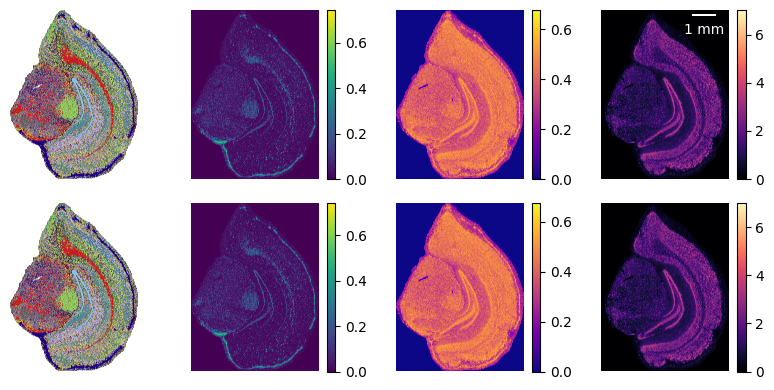

In [44]:
from matplotlib_scalebar.scalebar import ScaleBar

fig, axs = plt.subplots(2, 4, width_ratios=[1, 1.2, 1.2, 1.2], figsize=(8, 4))

# python
im = stereo.plot_celltypemap(
    return_img=True, cmap=cmap, background="white", remove_background=False
)

axs[0, 0].imshow(im, origin="lower")

im = axs[0, 1].imshow(
    stereo.assignment_score.T, origin="lower", cmap=assignment_score_cmap
)
fig.colorbar(im, ax=axs[0, 1])

im = axs[0, 2].imshow(stereo.cosine_similarity.T, origin="lower", cmap=cosine_cmap)
fig.colorbar(im, ax=axs[0, 2])

im = axs[0, 3].imshow(stereo.total_mRNA_KDE.T, origin="lower", cmap=kde_cmap)
fig.colorbar(im, ax=axs[0, 3])

axs[0, 3].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))

# julia
axs[1, 0].imshow(ct_im_jl, origin="lower")

im = axs[1, 1].imshow(assignment_score_jl, origin="lower", cmap=assignment_score_cmap)
fig.colorbar(im, ax=axs[1, 1])

im = axs[1, 2].imshow(cosine_similarity_jl, origin="lower", cmap=cosine_cmap)
fig.colorbar(im, ax=axs[1, 2])

im = axs[1, 3].imshow(kde_jl, origin="lower", cmap=kde_cmap)
fig.colorbar(im, ax=axs[1, 3])

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].set_axis_off()

fig.tight_layout()

In [45]:
fig.savefig("figures/Sainsc_vs_Sainsc.pdf", dpi=600)